In [19]:
%matplotlib inline 
# import the necessary packages
import numpy as np
import argparse
import glob
import cv2 #need to install on this kernel
from PIL import Image
import matplotlib.pyplot as plt
from skimage.filters import sobel, roberts
from skimage import feature
from skimage import measure
from skimage import morphology
from collections import Counter
import operator
from scipy import ndimage as ndi
from skimage import io

In [20]:
#parameters
lowClip = 6 # Percent of original image
highClip = 40

In [21]:
#choosing image
filename= '43378-17.png'
#filename= '43386-17.png'
#filename = "43375-17.png" # Strong
#filename = "43396-17.png" # Strong

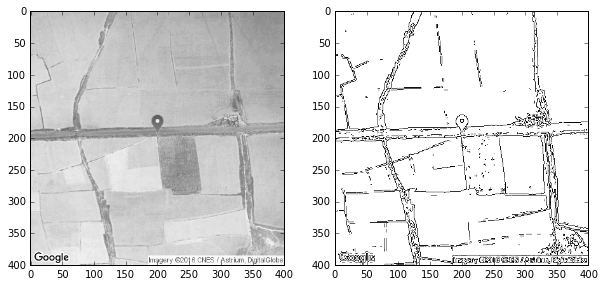

In [22]:
sigma=0.1

#use opencv
def auto_canny(image, sigma=.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
 
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
 
    # return the edged image
    return edged

# load the image, convert it to grayscale, and blur it slightly
image = cv2.imread(filename)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (1, 1), 0) #ksize – Gaussian kernel size. 
#ksize.width and ksize.height can differ but they both must be positive and odd. 
#Or, they can be zero’s and then they are computed from sigma*

# apply Canny edge detection using a wide threshold, tight
# threshold, and automatically determined threshold
auto = auto_canny(blurred, sigma)
#auto = auto_canny(image) #play arround with blurred,gray, orig
#inv=(auto==0)*1
#ret, markers = cv2.connectedComponents(inv)


# show the images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.imshow(blurred, cmap="Greys")
ax2.imshow(auto, cmap="Greys")
plt.show()
#cv2.imshow("Original", image)
#cv2.imshow("Edges", np.hstack([ auto]))  #wide, tight,

[]

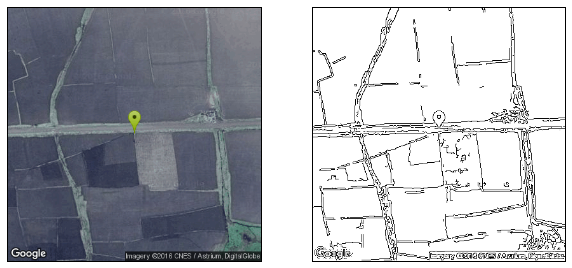

In [23]:
im = io.imread(filename, as_grey=True) #import image
im2 = io.imread(filename) #store a second version
imarr = np.asarray(im) #transform to numpy array

#use skimage
sigma=.8 #parameter for canny edge detection
edge_canny = feature.canny(imarr, sigma) 

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10)) 
ax1.imshow(im2, cmap="Greys")
ax1.set_xticks([])
ax1.set_yticks([])
ax2.imshow(edge_canny, cmap="Greys")
ax2.set_xticks([])
ax2.set_yticks([])

In [24]:
#dilation to close edges
#dilat2 = morphology.binary_dilation(edge_canny) #uses output from skimage
dilat2 = morphology.binary_dilation(auto) #uses output from opencv 
dilat = morphology.binary_dilation(dilat2)

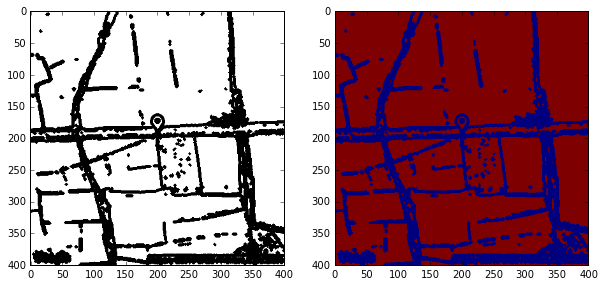

In [25]:
mask=(dilat==0)*1 #invert image

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10)) #sharey=False)
ax1.imshow(dilat, cmap="Greys") #graph dilation
ax2.imshow(mask, cmap="Greys") #graph inverse
plt.imshow(mask,)

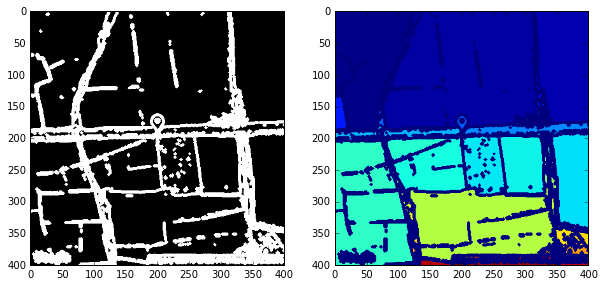

In [26]:
label_image = measure.label(mask)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10)) #sharey=False)
ax1.imshow(mask, cmap="Greys")
ax2.imshow(label_image)

In [27]:
pix = label_image.ravel()
rgns = Counter(pix)
sorted_rgns = np.asarray(sorted(rgns.items(), key=operator.itemgetter(1)))
lowerLimit = (lowClip/100)**2.0*np.shape(imarr)[0]*np.shape(imarr)[1]
upperLimit = (highClip/100)**2.0*np.shape(imarr)[0]*np.shape(imarr)[1]
mask2 = ((sorted_rgns[:,1] > lowerLimit) & (sorted_rgns[:,1] < upperLimit))
zones = sorted_rgns[mask2][:,0]

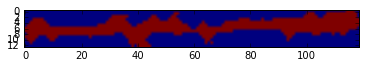

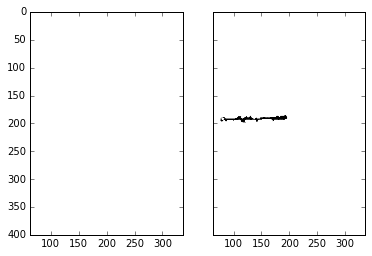

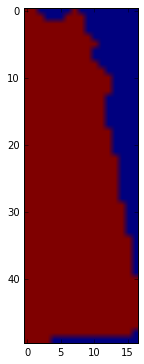

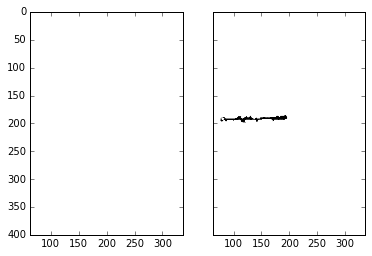

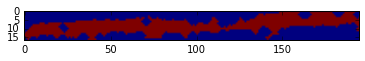

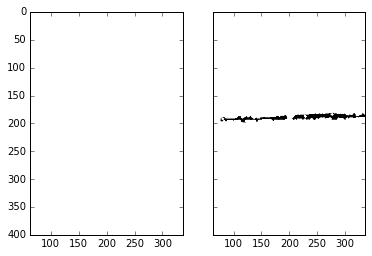

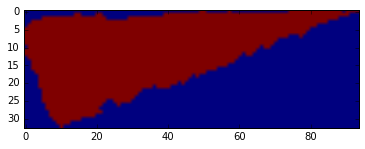

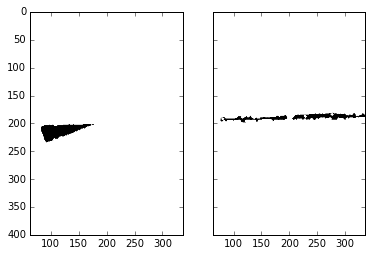

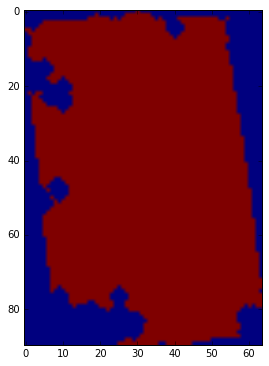

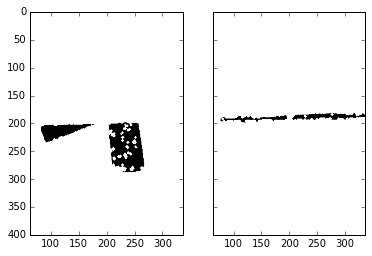

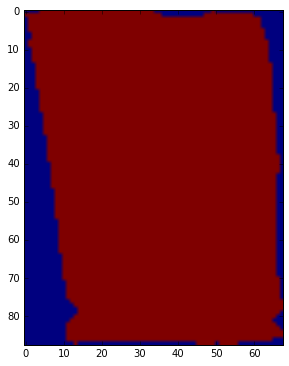

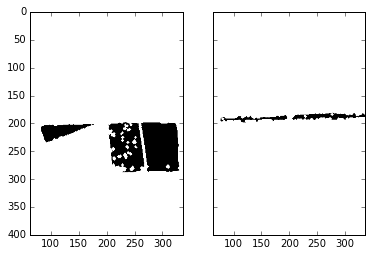

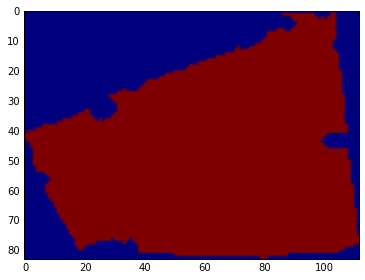

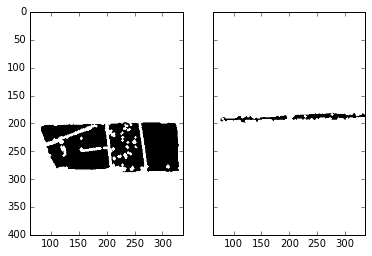

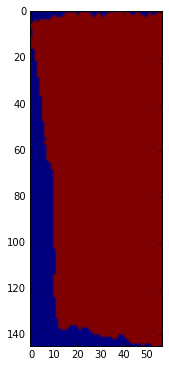

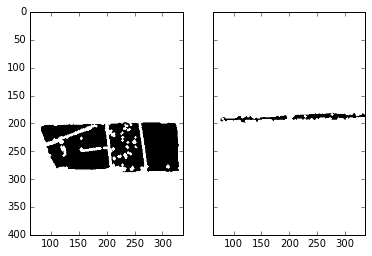

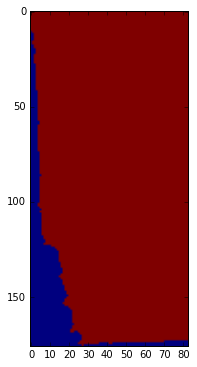

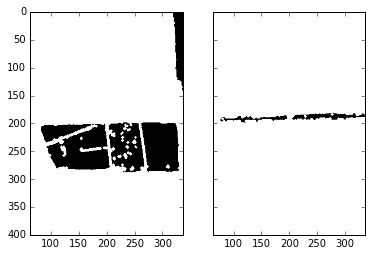

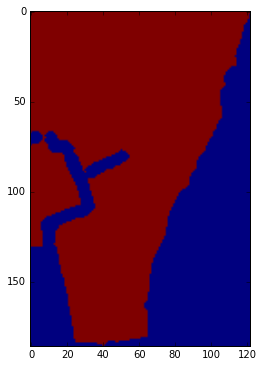

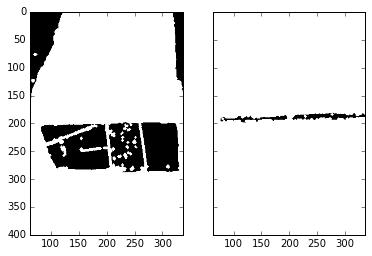

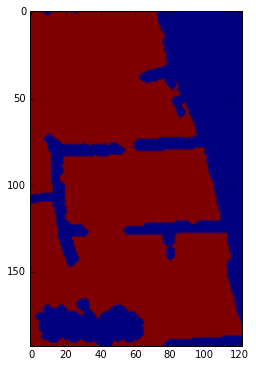

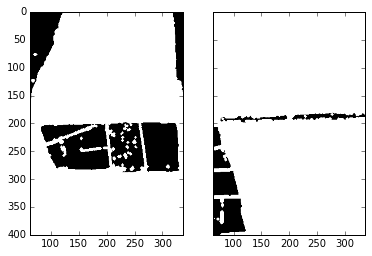

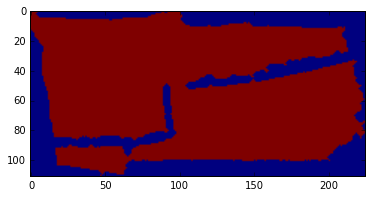

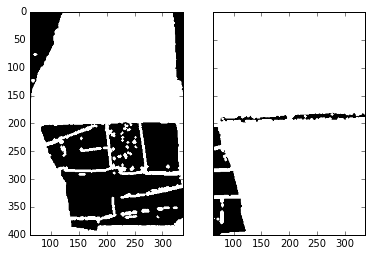

In [28]:
maskred = np.zeros_like(imarr)
maskgreen = np.zeros_like(imarr)

for z in zones:        
    zone = (label_image==z)*1
    bboxes = ndi.measurements.find_objects(zone)
    zoneCropHoles = zone[bboxes[0][0].start:bboxes[0][0].stop, bboxes[0][1].start:bboxes[0][1].stop]
    zoneCrop = ndi.binary_fill_holes(zoneCropHoles)
    plt.figure(figsize=(6,6))
    plt.imshow(zoneCrop)
    #plt.colorbar()
    plt.show()
    zoneCroppad = np.lib.pad(zoneCrop,(1,1),'constant',constant_values=0)
    edgeIm = sobel(zoneCroppad.astype('float64'))
    edgeIm[edgeIm > 0.01] = 1
    #need to improve field criteria, possiblly use 
    #harris edge detection
    if(sum(sum(edgeIm))/(2*(sum(np.asarray(np.shape(zoneCrop))))) > 4 \
        or max(np.shape(zoneCrop))/min(np.shape(zoneCrop)) > 4): 
        maskred[zone==1]=1
    else:
        maskgreen[zone==1]=1
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax1.imshow(maskgreen, cmap="Greys")
    ax2.imshow(maskred, cmap="Greys")
    plt.show()

[]

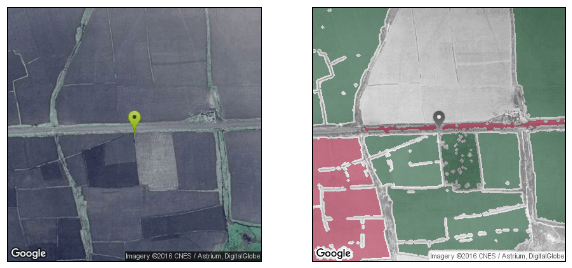

In [29]:
gmasked = np.ma.masked_where(maskgreen < 0.9, maskgreen)
rmasked = np.ma.masked_where(maskred < 0.9, maskred)
plt.figure(figsize=(6,6))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10)) #sharey=False)
ax1.imshow(im2)
ax1.set_xticks([])
ax1.set_yticks([])
ax2.imshow(imarr, cmap="Greys")
ax2.imshow(gmasked, alpha=0.5, cmap="PRGn_r")
ax2.imshow(rmasked, alpha=0.5, cmap="RdYlBu")
plt.gca().set_xticks([])
plt.gca().set_yticks([])